## Predictive Modeling of Cryptocurrency Prices
STA 208 - Spring 2021  
Group: Noah Perry

In [2]:
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from statsmodels.tsa.api import VAR

os.chdir("C:/Users/noahj/Documents/UCD/2021 Spring Classes/STA 208/Project/STA208_FinalProject_NoahPerry/Data")
main = pd.read_pickle("main.pkl")

**Model: Vector Autoregression**  
The first kind of model that I test is vector autoregression. As shown in the code below, I evaluate the performance of each model through nested cross validation, where the training set only includes observations that occur prior to the observations in the test set. Each test set contains approximately two weeks of data. Then, I define a simplistic performance metric of whether the model correctly predicts the sign of price movements. This is tied to the use case of investing in cryptocurrency because a model that can correctly predict whether the price will increase or decrease would help a investor decide whether to buy, sell, short sell, etc. a particularly cryptocurrency on a given day. 

As described below, the model containing the daily log difference of the prices performs no better than flipping a coin to guess whether the prices will increase or decrease. However, the predictive performance improves for the weekly log differenced prices and is even better for the biweekly log differenced prices, reaching accuracy over 70 percent in some models.

In [3]:
def vec_ar(varlist, lags, perf_varlist):
    """
    varlist: variables to be used in vector autoregression
    lags: number of lags of each variable
    perf_varlist: variables for which the performance metric will be calculated
    """
    data = main[varlist]
        
    # Restrict data to feature/target with shortest time series
    data = data.dropna(axis = 0)
    
    # Reset index for TimeSeriesSplit()
    data = data.reset_index(drop = True)

    # Back testing / cross validation    
    splits = math.floor(data.shape[0]/14)
        # Each test set to contain around 14 data points
    tscv_results = pd.DataFrame()
    tscv = model_selection.TimeSeriesSplit(n_splits = splits)
    for train_index, test_index in tscv.split(data):
        # Construct training and test sets
        data_tr, data_te = data.iloc[train_index,], data.iloc[test_index,]
        
        # Fit vector autoregression model
        model = VAR(data_tr)   
        results = model.fit(lags)
        
        # Make predictions
        pred = results.forecast(results.endog, steps = data_te.shape[0])
             
        # Performance metric: percent of predicted signs that match actual sign
        c = ["pred_" + v for v in varlist]
        pred_df = pd.DataFrame(pred, columns = c)  
        pred_df = pred_df.set_index(data_te.index)
        
        comparison = pred_df.merge(data_te, left_index = True, right_index = True)
        
        # Loop over all variables in perf_varlist and calculate performance metrics for each one
        for p in perf_varlist:
            comparison["pred_sign_" + p] = np.where(comparison["pred_" + p] >= 0, "positive", "negative")
            comparison["actual_sign_" + p] = np.where(comparison[p] >= 0, "positive", "negative")
            comparison["same_sign_" + p] = (comparison["pred_sign_" + p] == comparison["actual_sign_" + p]).astype(int)

        tscv_results = tscv_results.append(comparison)
        
    return(tscv_results)

------------
**Set 1:** The first set of vector autoregression models that I test include the daily log differenced prices for Cardano (ADA), Monero (XMR), Bitcoin (XBT), and Ethereum (ETH) with 1, 2, 7, 14, and 30 lags of each variable. As shown in the table and chart below, I find that each model in this set correctly predicts the sign about 50 percent of the time, which is basically no better than guessing by flipping a coin. 

I also plotted histograms of the predicted prices for Cardano and Monero for the models with daily log differenced prices and 1 lag of each variable. These histograms reveal that the model predicts daily log differenced prices of essentially 0 for the vast majority of observations. Since the price chart of the daily log differenced prices appeared to be random noise around 0 and the autocorrelation plot showed very little correlation in the daily change in price, this result is not surprising.

In [17]:
# Vector autoregression models including daily log differenced ADA, XMR, XBT, and ETH prices with 1, 2, 7, 14, and 30 lags
vec_ar1 = []
vec_ar1_perf_ADA = []
vec_ar1_perf_XMR = []
vec_ar1_perf_ETH = []
vec_ar1_perf_XBT = []
counter = 0
for i in [1,2,7,14,30]:
    vec_ar1 = vec_ar1 + [vec_ar(["logdif_ADA", "logdif_XMR", "logdif_XBT", "logdif_ETH"], i, ["logdif_ADA", "logdif_XMR", "logdif_XBT", "logdif_ETH"])]
    vec_ar1_perf_ADA = vec_ar1_perf_ADA + [(vec_ar1[counter]["same_sign_logdif_ADA"] == 1).sum() / vec_ar1[0].shape[0]]
    vec_ar1_perf_XMR = vec_ar1_perf_XMR + [(vec_ar1[counter]["same_sign_logdif_XMR"] == 1).sum() / vec_ar1[0].shape[0]]
    vec_ar1_perf_ETH = vec_ar1_perf_ETH + [(vec_ar1[counter]["same_sign_logdif_ETH"] == 1).sum() / vec_ar1[0].shape[0]]
    vec_ar1_perf_XBT = vec_ar1_perf_XBT + [(vec_ar1[counter]["same_sign_logdif_XBT"] == 1).sum() / vec_ar1[0].shape[0]]    
    counter = counter + 1

In [18]:
# Table of Proportion of Signs Predicted Correctly
pd.DataFrame({"lags": [1,2,7,14,30], "pct_correct_ADA": vec_ar1_perf_ADA, "pct_correct_XMR": vec_ar1_perf_XMR, "pct_correct_ETH": vec_ar1_perf_ETH, "pct_correct_XBT": vec_ar1_perf_XBT})  

,lags,pct_correct_ADA,pct_correct_XMR,pct_correct_ETH,pct_correct_XBT
0,1,0.500592,0.502959,0.527811,0.524260
1,2,0.514793,0.512426,0.534911,0.525444
2,7,0.484024,0.520710,0.507692,0.525444
3,14,0.492308,0.506509,0.500592,0.498225
4,30,0.502959,0.492308,0.510059,0.497041


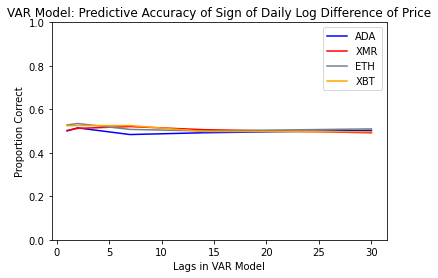

In [35]:
# Plot performance
plt.plot([1,2,7,14,30], vec_ar1_perf_ADA, label = "ADA", color = "blue")
plt.plot([1,2,7,14,30], vec_ar1_perf_XMR, label = "XMR", color = "red")
plt.plot([1,2,7,14,30], vec_ar1_perf_ETH, label = "ETH", color = "slategray")
plt.plot([1,2,7,14,30], vec_ar1_perf_XBT, label = "XBT", color = "orange")
plt.title("VAR Model: Predictive Accuracy of Sign of Daily Log Difference of Price")
plt.ylim(0,1)
plt.xlabel("Lags in VAR Model")
plt.ylabel("Proportion Correct")
plt.legend()

Text(0, 0.5, 'Frequency')

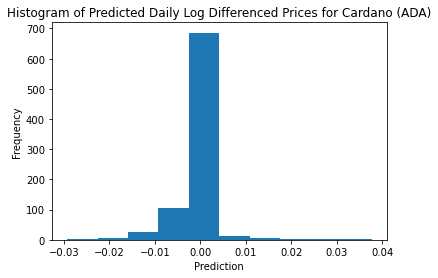

In [26]:
# Histogram of Predicted Daily Log Difference Price Values for Cardano (ADA), Model with 1 Lag of Each Variable
plt.hist(vec_ar1[0]["pred_logdif_ADA"])
plt.title("Histogram of Predicted Daily Log Differenced Prices for Cardano (ADA)")
plt.xlabel("Prediction")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

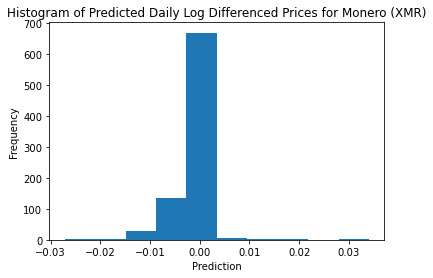

In [27]:
# Histogram of Predicted Daily Log Difference Price Values for Monero (XMR), Model with 1 Lag of Each Variable
plt.hist(vec_ar1[0]["pred_logdif_XMR"])
plt.title("Histogram of Predicted Daily Log Differenced Prices for Monero (XMR)")
plt.xlabel("Prediction")
plt.ylabel("Frequency")

----------------------------
**Set 2:** The second set of vector autoregression models, which involves the weekly log differenced prices, performs slightly better than the first set of models. The models correctly predict the signs of the weekly log differenced prices between 54 and 65 percent of the time. Similar to the first set, the number of lags of each variable included in each model does not appear to make a substantial difference in the performance.

In [5]:
# Vector autoregression models including weekly log differenced ADA, XMR, XBT, and ETH prices with 1, 2, 7, 14, and 30 lags
vec_ar2 = []
vec_ar2_perf_ADA = []
vec_ar2_perf_XMR = []
vec_ar2_perf_ETH = []
vec_ar2_perf_XBT = []
counter = 0
for i in [1,2,7,14,30]:
    vec_ar2 = vec_ar2 + [vec_ar(["logdif7_ADA", "logdif7_XMR", "logdif7_XBT", "logdif7_ETH"], i, ["logdif7_ADA", "logdif7_XMR", "logdif7_XBT", "logdif7_ETH"])]
    vec_ar2_perf_ADA = vec_ar2_perf_ADA + [(vec_ar2[counter]["same_sign_logdif7_ADA"] == 1).sum() / vec_ar2[0].shape[0]]
    vec_ar2_perf_XMR = vec_ar2_perf_XMR + [(vec_ar2[counter]["same_sign_logdif7_XMR"] == 1).sum() / vec_ar2[0].shape[0]]
    vec_ar2_perf_ETH = vec_ar2_perf_ETH + [(vec_ar2[counter]["same_sign_logdif7_ETH"] == 1).sum() / vec_ar2[0].shape[0]]
    vec_ar2_perf_XBT = vec_ar2_perf_XBT + [(vec_ar2[counter]["same_sign_logdif7_XBT"] == 1).sum() / vec_ar2[0].shape[0]]    
    counter = counter + 1

In [6]:
# Table of Proportion of Signs Predicted Correctly
pd.DataFrame({"lags": [1,2,7,14,30], "pct_correct_ADA": vec_ar2_perf_ADA, "pct_correct_XMR": vec_ar2_perf_XMR, "pct_correct_ETH": vec_ar2_perf_ETH, "pct_correct_XBT": vec_ar2_perf_XBT})  

,lags,pct_correct_ADA,pct_correct_XMR,pct_correct_ETH,pct_correct_XBT
0,1,0.593750,0.545673,0.585337,0.574519
1,2,0.579327,0.548077,0.593750,0.576923
2,7,0.579327,0.566106,0.544471,0.586538
3,14,0.587740,0.602163,0.608173,0.604567
4,30,0.608173,0.596154,0.582933,0.644231


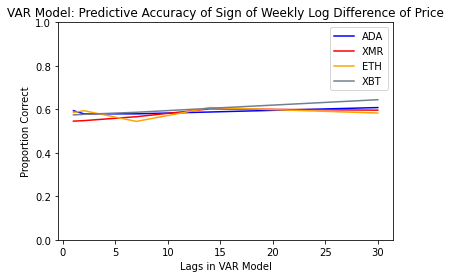

In [29]:
# Plot performance
plt.plot([1,2,7,14,30], vec_ar2_perf_ADA, label = "ADA", color = "blue")
plt.plot([1,2,7,14,30], vec_ar2_perf_XMR, label = "XMR", color = "red")
plt.plot([1,2,7,14,30], vec_ar2_perf_ETH, label = "ETH", color = "slategray")
plt.plot([1,2,7,14,30], vec_ar2_perf_XBT, label = "XBT", color = "orange")
plt.title("VAR Model: Predictive Accuracy of Sign of Weekly Log Difference of Price")
plt.ylim(0,1)
plt.xlabel("Lags in VAR Model")
plt.ylabel("Proportion Correct")
plt.legend()

--------------------
**Set 3:** The third set of vector autoregression models involved the biweekly log differenced prices. These models perform better that the models in the first two sets. The predictive accuracy of the models in set 3 range from 66 to 74 percent. Similar to sets 1 and 2, the number of lags of each variable included in the vector autoregression only results in small changes in predictive performance.

In [9]:
# Vector autoregression models including biweekly log differenced ADA, XMR, XBT, and ETH prices with 1, 2, 7, 14, and 30 lags
vec_ar3 = []
vec_ar3_perf_ADA = []
vec_ar3_perf_XMR = []
vec_ar3_perf_ETH = []
vec_ar3_perf_XBT = []
counter = 0
for i in [1,2,7,14,30]:
    vec_ar3 = vec_ar3 + [vec_ar(["logdif14_ADA", "logdif14_XMR", "logdif14_XBT", "logdif14_ETH"], i, ["logdif14_ADA", "logdif14_XMR", "logdif14_XBT", "logdif14_ETH"])]
    vec_ar3_perf_ADA = vec_ar3_perf_ADA + [(vec_ar3[counter]["same_sign_logdif14_ADA"] == 1).sum() / vec_ar3[0].shape[0]]
    vec_ar3_perf_XMR = vec_ar3_perf_XMR + [(vec_ar3[counter]["same_sign_logdif14_XMR"] == 1).sum() / vec_ar3[0].shape[0]]
    vec_ar3_perf_ETH = vec_ar3_perf_ETH + [(vec_ar3[counter]["same_sign_logdif14_ETH"] == 1).sum() / vec_ar3[0].shape[0]]
    vec_ar3_perf_XBT = vec_ar3_perf_XBT + [(vec_ar3[counter]["same_sign_logdif14_XBT"] == 1).sum() / vec_ar3[0].shape[0]]    
    counter = counter + 1

In [10]:
# Table of Proportion of Signs Predicted Correctly
pd.DataFrame({"lags": [1,2,7,14,30], "pct_correct_ADA": vec_ar3_perf_ADA, "pct_correct_XMR": vec_ar3_perf_XMR, "pct_correct_ETH": vec_ar3_perf_ETH, "pct_correct_XBT": vec_ar3_perf_XBT})  

,lags,pct_correct_ADA,pct_correct_XMR,pct_correct_ETH,pct_correct_XBT
0,1,0.729567,0.687500,0.679087,0.704327
1,2,0.729567,0.700721,0.686298,0.719952
2,7,0.698317,0.737981,0.670673,0.715144
3,14,0.669471,0.736779,0.686298,0.736779
4,30,0.670673,0.683894,0.669471,0.725962


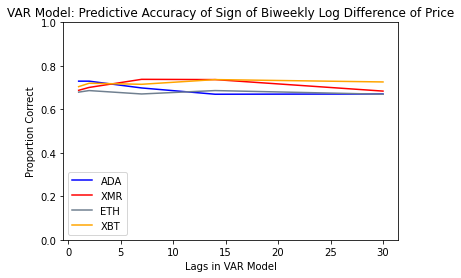

In [34]:
# Plot performance
plt.plot([1,2,7,14,30], vec_ar3_perf_ADA, label = "ADA", color = "blue")
plt.plot([1,2,7,14,30], vec_ar3_perf_XMR, label = "XMR", color = "red")
plt.plot([1,2,7,14,30], vec_ar3_perf_ETH, label = "ETH", color = "slategray")
plt.plot([1,2,7,14,30], vec_ar3_perf_XBT, label = "XBT", color = "orange")
plt.title("VAR Model: Predictive Accuracy of Sign of Biweekly Log Difference of Price")
plt.ylim(0,1)
plt.xlabel("Lags in VAR Model")
plt.ylabel("Proportion Correct")
plt.legend()

**Ideas for Further Analysis**  
- Using training set of fixed size instead of all observations prior to test set
- Additional performance metrics involving magnitude of price change in addition to sign to quantify profitability of a trading strategy that is based on the model's predictions.
- Test monthly log difference or other variations of log differenced price